In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.metrics import mean_squared_error

from src.simpleEDMD import *
import src.dictionary_strategy as d_strategy

%load_ext autoreload
%autoreload 2
%matplotlib inline

np.set_printoptions(suppress=True,precision=4)

# Analytical Solution

In [2]:
def analytical_koopman_eigenfunction(x,y,i,j):
    return np.power((x-y)/np.sqrt(2),i)*np.power(y,j)

def analytical_koopman_eigenvalue(i,j):
    return np.power(0.9,i)*np.power(0.8,j)


In [3]:
x1 = np.arange(-5, 5.1, 0.1)
x2 = np.arange(-5, 5.1, 0.1)
xx1, xx2 = np.meshgrid(x1, x2)

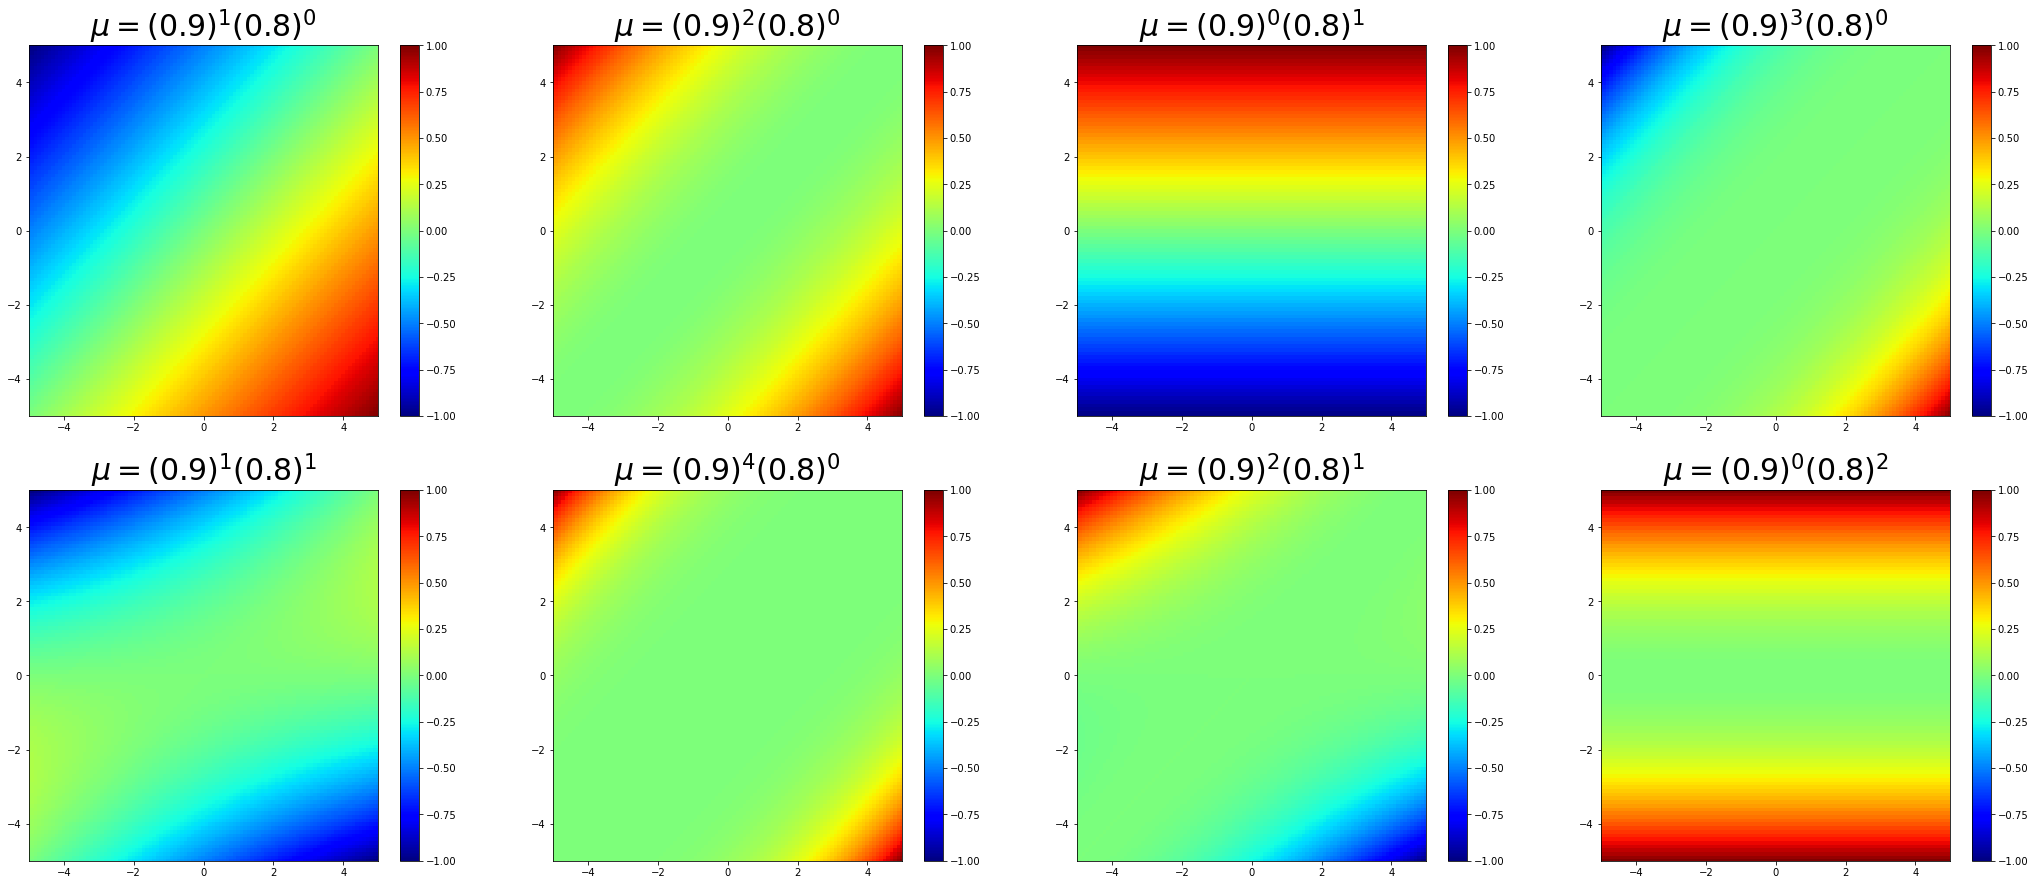

In [4]:
fig, axs = plt.subplots(2, 4,figsize=(36,15))
ij = [[1,0],[2,0],[0,1],[3,0],[1,1],[4,0],[2,1],[0,2]] #normalized to [-1,1]
for index, power in enumerate(ij):
    
    i = power[0]
    j = power[1]

    z = analytical_koopman_eigenfunction(xx1,xx2,i,j)
   
    temp = z.flatten()
    inf_norm = np.linalg.norm(temp, np.inf)
    normalized_z = np.array( [v/inf_norm for v in z])

    if index < 4:
        ax = axs[0,index]
    else:
        ax = axs[1,index-4]
    c = ax.pcolor(x1, x2, normalized_z, cmap='jet', vmin=-1, vmax=1, shading='auto')
    ax.set_title('$\mu = (0.9)^{}(0.8)^{}$'.format(i,j),fontsize = 30)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    fig.colorbar(c, ax=ax)

# Random Normal Data generation
for example4.1.1

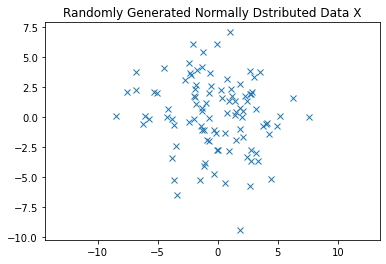

In [5]:
#generate X as 100 normally distributed initial conditions 2x100
mean = [0, 0]
cov = [[10, 0], [0, 10]]
x1, x2 = np.random.multivariate_normal(mean, cov, 100).T
plt.plot(x1, x2, 'x')
plt.axis('equal')
plt.title('Randomly Generated Normally Dstributed Data X')
plt.show()

X = []
for i in range(0,100):
    X.append([x1[i],x2[i]])
X = np.array(X)

In [6]:
#generate true Y by multiplying J
J = np.array([[0.9, -0.1],[0, 0.8]])
Y = []
for i in range(0,100):
    xi = X[i]
    yi = J@xi
    Y.append(yi)

Y = np.array(Y)

In [7]:
Y.shape

(100, 2)

# EDMD Solution

In [8]:
herimite_strategy = d_strategy.Herimite_strategy()
linearEDMD = simpleEDMD(X,Y, herimite_strategy)

In [9]:
linearEDMD.compute_koopman_operator()

In [10]:
K = linearEDMD.koopman_matrix

## Koopman Eigenvalues

In [11]:
Mu = linearEDMD.koopman_eigenvalues
Mu # correctly responding to eigenvalues in Fig.3

array([1.    +0.j    , 0.9   +0.j    , 0.81  +0.j    , 0.8   +0.j    ,
       0.729 +0.j    , 0.72  +0.j    , 0.6561+0.j    , 0.648 +0.j    ,
       0.64  +0.j    , 0.61  +0.j    , 0.5832+0.j    , 0.576 +0.j    ,
       0.5184+0.j    , 0.512 +0.j    , 0.4795+0.j    , 0.4608+0.j    ,
       0.4096+0.j    , 0.4096+0.j    , 0.3823+0.j    , 0.3533+0.0908j,
       0.3533-0.0908j, 0.3121+0.1868j, 0.3121-0.1868j, 0.2395+0.0518j,
       0.2395-0.0518j])

## Koopman Eigenfunctions

In [12]:
Xi = linearEDMD.right_eigenvectors
Xi.shape

(25, 25)

In [13]:
x1 = np.arange(-5, 5.1, 0.1)
x2 = np.arange(-5, 5.1, 0.1)
xx1, xx2 = np.meshgrid(x1, x2)
test_X = np.array([xx1.reshape(-1), xx2.reshape(-1)])
test_X = test_X.T

In [14]:
#Psi = linearEDMD.dictionary_Hermite_poly(test_X)
#eZ = Psi@Xi.real

Phi = linearEDMD.compute_koopman_eigenfunctions(test_X).real
Phi.shape

(10201, 25)

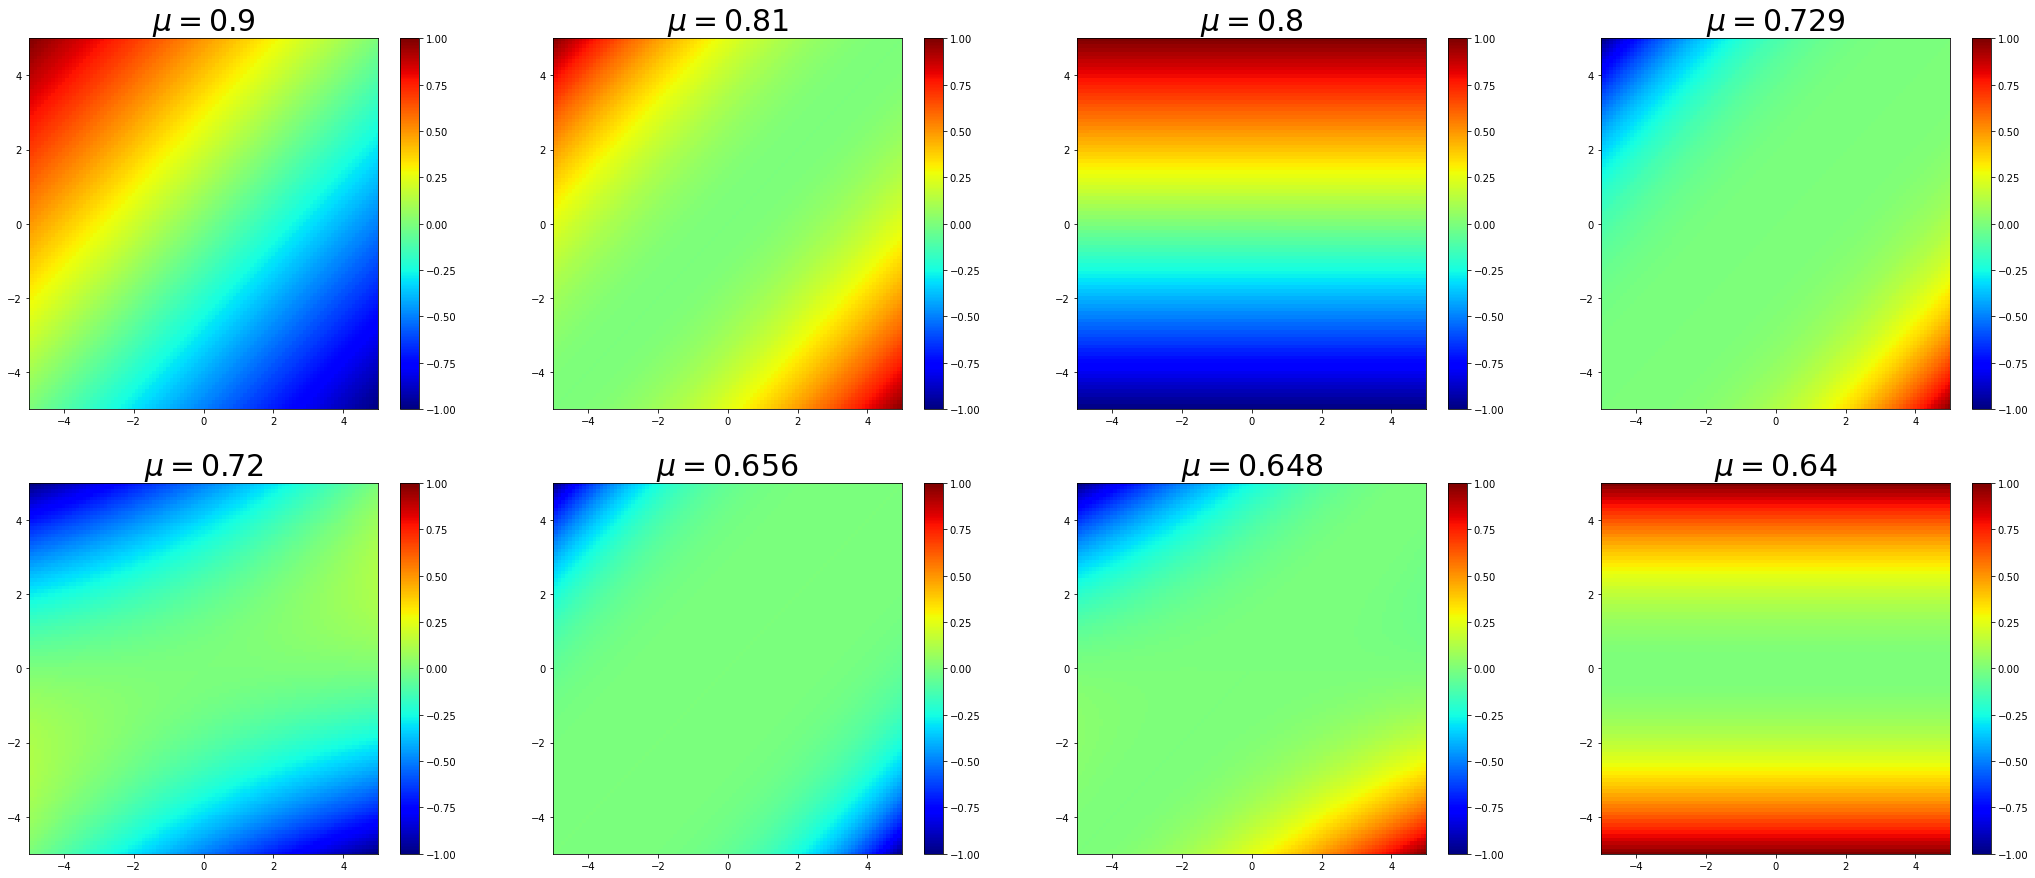

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(36,15))

for index in range(1,9):
    temp = Phi[:, index].flatten()
    inf_norm = np.linalg.norm(temp, np.inf)
    normalized_Phi = np.array( [v/inf_norm for v in temp])

    if index <= 4:
        ax = axs[0,index -1]
    else:
        ax = axs[1,index-5]
    normalized_Phi = normalized_Phi.reshape(xx1.shape[0],xx1.shape[1])

    c = ax.pcolor(x1, x2, normalized_Phi, cmap='jet', vmin=-1, vmax=1, shading='auto')
    
    ax.set_title('$\mu = {}$'.format(np.round(Mu[index].real,3)),fontsize = 30)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    fig.colorbar(c, ax=ax)

## Koopman Modes

In [16]:
Wstar = linearEDMD.left_eigenvectors
w = linearEDMD.levecs

print('Unscaled 2nd left eigenvector: ' , w[:,1])
print('Scaled 2nd left eigenvector: ' , Wstar[:,1])
print('w_2@xi_2 = 1 : ', Wstar[:,24]@Xi[:,24]) # = 1 , scaled correctly

Unscaled 2nd left eigenvector:  [ 0.    +0.j -0.0055+0.j  0.    +0.j  0.0014+0.j  0.    +0.j  0.    +0.j
  0.    +0.j  0.    +0.j  0.    +0.j -0.    +0.j  0.    +0.j -0.    +0.j
 -0.    +0.j -0.    +0.j  0.    +0.j  0.    +0.j -0.    +0.j -0.    +0.j
 -0.    +0.j  0.    +0.j  0.    -0.j -0.    +0.j -0.    -0.j  0.    +0.j
  0.    -0.j]
Scaled 2nd left eigenvector:  [  -0.    +0.j   -1.4142-0.j   -0.    +0.j    2.1213+0.j    0.    -0.j
    0.    -0.j   -0.    +0.j    0.    -0.j    0.    -0.j    0.0266-0.j
    0.    -0.j    0.7071+0.j    0.    -0.j   -1.0911-0.j   -2.7531+0.j
   -0.    +0.j   -0.    -0.j    0.0564-0.j    4.4337+0.j   10.0211-0.j
   -0.    +0.j   -1.2332-0.j  -10.0883-0.j  -20.846 +0.j -257.2613-0.j]
w_2@xi_2 = 1 :  (1.0000000000000013+2.282896094385478e-15j)


In [17]:
B = linearEDMD.B
B # correct as stated in paper

array([[ 0.,  0.],
       [ 1., -0.],
       [ 0.,  0.],
       [-0.,  0.],
       [-0., -0.],
       [-0.,  1.],
       [-0.,  0.],
       [ 0., -0.],
       [ 0., -0.],
       [-0.,  0.],
       [-0., -0.],
       [-0.,  0.],
       [ 0.,  0.],
       [ 0., -0.],
       [-0., -0.],
       [ 0., -0.],
       [-0.,  0.],
       [-0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0., -0.],
       [-0., -0.],
       [-0.,  0.],
       [ 0.,  0.]])

In [18]:
V = linearEDMD.koopman_modes
print('2nd left eigenvector of J/mode: ', V [:,1]) #correct
print('4th left eigenvector of J/mode: ', V [:,3]) #correct
V.shape

2nd left eigenvector of J/mode:  [-1.4142-0.j  0.    -0.j]
4th left eigenvector of J/mode:  [1.-0.j 1.-0.j]


(2, 25)

# Predict X_n+1

In [19]:
Y_predicted  = linearEDMD.predict_next_timestep(X).real
MSE = mean_squared_error(Y,Y_predicted)

Text(0.5, 1.0, 'Predicted Y and True Y with MSE = 3.93697821501875e-18')

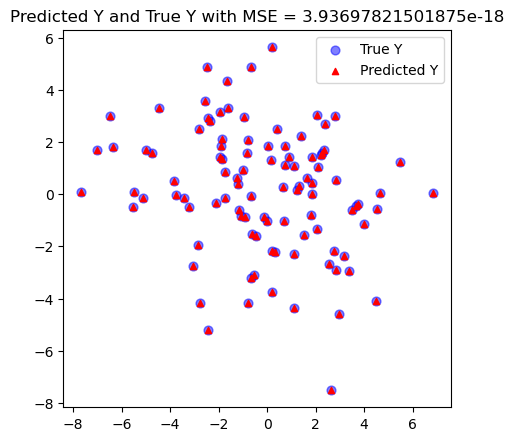

In [20]:
plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(Y[:,0],Y[:,1], c = 'b', alpha = 0.5, s = 40, label='True Y')
plt.scatter(Y_predicted[:,0],Y_predicted[:,1], s = 20, c = 'r', marker = '^', label='Predicted Y')
plt.legend()
plt.title("Predicted Y and True Y with MSE = {}".format(MSE))

Text(0.5, 1.0, 'Timestep 100 with MSE = 9.70829602241991e-16')

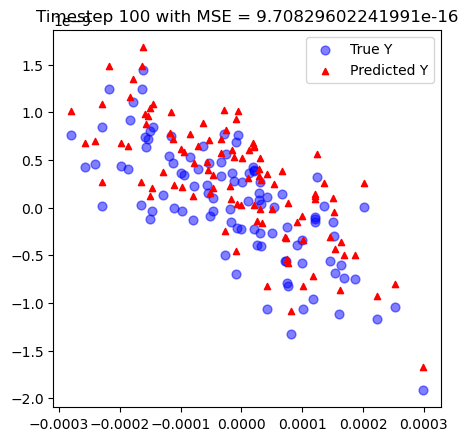

In [21]:
X_nplus1 = X
X_nplus1_predicted = X
n = 100
# predict ager n timestep
for t in range(n):
    X_nplus1 = X_nplus1@J.T
    X_nplus1_predicted  = linearEDMD.predict_next_timestep(X_nplus1_predicted).real

MSE = mean_squared_error(X_nplus1,X_nplus1_predicted)
plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X_nplus1[:,0],X_nplus1[:,1], c = 'b', alpha = 0.5, s = 40, label='True Y')
plt.scatter(X_nplus1_predicted[:,0],X_nplus1_predicted[:,1], s = 20, c = 'r', marker = '^', label='Predicted Y')
plt.legend()
plt.title("Timestep {} with MSE = {}".format(n, MSE))
